# Ultimate radar dataset

In this notebook we create the ultimate external radar dataset so we can do the research outside Elta's systems.

This dataset is a merge between RADDet, CARRADA, CRUW and later others.

## Imports 

In [92]:
import os
import time
import glob
import json
import torch
import pickle
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt
from IPython.display import Image
from torchvision import transforms
import matplotlib.patches as patches
from torch.utils.data import Dataset
from torchvision.io import read_image
from torchvision.transforms.functional import to_pil_image
from carrada_dataset.carrada_dataset.utils import CARRADA_HOME
from carrada_dataset.carrada_dataset.utils.configurable import Configurable
from carrada_dataset.carrada_dataset.utils.transform_data import DataTransformer
from carrada_dataset.carrada_dataset.utils.visualize_signal import SignalVisualizer
from carrada_dataset.carrada_dataset.utils.generate_annotations import AnnotationGenerator
from carrada_dataset.carrada_dataset.utils.transform_annotations import AnnotationTransformer

## CRUW Dataset

### define data and annotations paths

In [93]:
data_path = '/home/hawk/Desktop/data/CRUW/TRAIN_RAD_H/'
anno_path = '/home/hawk/Desktop/data/CRUW/TRAIN_RAD_H_ANNO/'

### Load the data

In [94]:
def load_radar_data(data_path):
    radar_data = {}
    for folder in os.listdir(data_path):
        subfolder_path = os.path.join(data_path, folder, 'RADAR_RA_H')
        if os.path.isdir(subfolder_path):
            radar_files = sorted([os.path.join(subfolder_path, f) for f in os.listdir(subfolder_path) if f.endswith('.npy')])
            radar_data[folder] = [np.load(file) for file in radar_files]
    return radar_data

def load_annotations(anno_path):
    annotations = {}
    for file in os.listdir(anno_path):
        if file.endswith('.txt'):
            file_path = os.path.join(anno_path, file)
            with open(file_path, 'r') as f:
                lines = f.readlines()
                annotations[file[:-4]] = [line.strip().split() for line in lines]
    return annotations

radar_data = load_radar_data(data_path)
annotations = load_annotations(anno_path)
print(len(radar_data), "folders and ", len(annotations), "annotations")

40 folders and  40 annotations


### Combine the data and annotation

In [95]:
combined_data = []
for folder in radar_data:
    if folder in annotations:
        radar_frames = radar_data[folder]
        anno_lines = annotations[folder]
        frame_annotations = {}
        for line in anno_lines:
            index, x, y, label = line
            index = int(index)
            x, y = float(x), float(y)
            if index not in frame_annotations:
                frame_annotations[index] = []
            frame_annotations[index].append({
                'x': x,
                'y': y,
                'label': label
            })
        
        for frame_idx, radar_frame in enumerate(radar_frames):
            if frame_idx in frame_annotations:
                for anno in frame_annotations[frame_idx]:
                    combined_data.append({
                        'folder': folder,
                        'frame_index': frame_idx,
                        'radar_data': radar_frame,
                        'x': anno['x'],
                        'y': anno['y'],
                        'label': anno['label']
                    })

print(len(combined_data[1]))

6


### Plot the results

In [96]:
def plot_rd_map_with_bbox(df, folder, frame_index):
    data = df[(df['folder'] == folder) & (df['frame_index'] == frame_index)]
    if data.empty:
        print(f"No data found for folder {folder} and frame index {frame_index}")
        return
    
    radar_frame = data.iloc[0]['radar_data']
    
    plt.figure(figsize=(10, 10))
    plt.imshow(radar_frame[:, :, 1], cmap='jet', aspect='auto') 
    plt.colorbar()
    
    for _, row in data.iterrows():
        x, y, label = row['x'], row['y'], row['label']
        plt.scatter(x, y, s=50, edgecolors='white', facecolors='none', linewidths=2, label=label)
    
    plt.title(f"RD Map with Bounding Boxes for {folder}, Frame {frame_index}")
    plt.xlabel('Range')
    plt.ylabel('Doppler')
    plt.legend()
    plt.show()


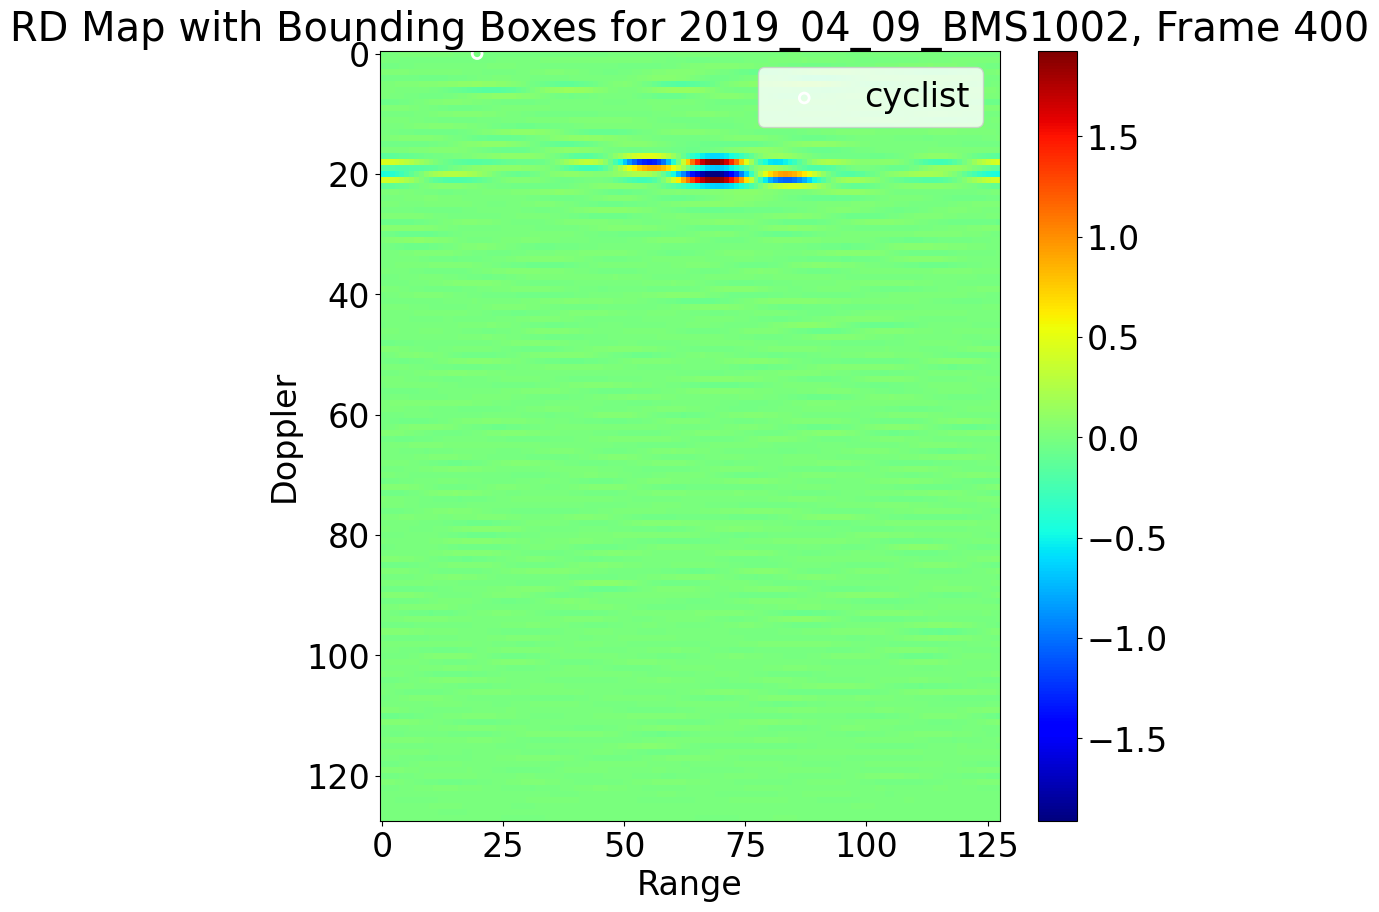

In [97]:
df = pd.DataFrame(combined_data)
plot_rd_map_with_bbox(df, '2019_04_09_BMS1002', 400)  # Change folder and frame_index as needed

## RADDet dataset

### loading from prev work, to check all is good

Here we only load part 9, which is the smallest part of the RADDet dataset, only for understanding and manipulation

The RADDet dataset contains 3 types of data - RAD tensors as npy files, gt as pickle files and stereo files as png

In [98]:
# Define folder paths
RAD_folder_path = '/home/hawk/Desktop/data/Raddet/train/RAD/part_9'
stereo_folder_path = '/home/hawk/Desktop/data/Raddet/train/stereo_image/part_9'
GT_folder_path = '/home/hawk/Desktop/data/Raddet/train/gt/part_9'

# Numpy files
all_RAD_files = os.listdir(RAD_folder_path)
RAD_files = [file for file in all_RAD_files if file.endswith('.npy')]
RAD_files_paths = [os.path.join(RAD_folder_path, file) for file in RAD_files]

# Ground truth files
all_GT_files = os.listdir(GT_folder_path)
GT_files = [file for file in all_GT_files if file.endswith('.pickle')]
GT_files_paths = [os.path.join(GT_folder_path, file) for file in all_GT_files]

# Stereo image files
all_stereo_files = os.listdir(stereo_folder_path)
stereo_files = [file for file in all_stereo_files if file.endswith('.jpg')]
stereo_files_paths = [os.path.join(stereo_folder_path, file) for file in all_stereo_files]

random_samples = random.sample(RAD_files_paths, 1)

Here we load the npy files, show how many were loaded and what they contain

In [99]:
all_loaded_RAD_files = []
for file in RAD_files_paths:
    loaded_file = np.load(file)
    all_loaded_RAD_files.append(loaded_file)
print(f'number of RAD files loaded: {len(all_loaded_RAD_files)}')
print(f'each RAD file is of size: {all_loaded_RAD_files[0].shape} which stands for: (Range, Azimuth, Doppler)')

number of RAD files loaded: 126
each RAD file is of size: (256, 256, 64) which stands for: (Range, Azimuth, Doppler)


Here we load the pickle files, they contain info about classes, boxes and cart boxes.

cart boxes means cartesian boxes

In [100]:
all_loaded_GT_files = []
for file in GT_files_paths:
    with open(file, 'rb') as f:  
        ground_truth = pickle.load(f) 
    all_loaded_GT_files.append(ground_truth)
print(f'number of GT files loaded: {len(all_loaded_GT_files)}')
print(f'each GT file is a dict with length 3: classes, boxes and cart_boxes. an example:')
print(all_loaded_GT_files[0])

number of GT files loaded: 126
each GT file is a dict with length 3: classes, boxes and cart_boxes. an example:
{'classes': ['truck', 'car', 'car', 'car'], 'boxes': array([[177.5, 173. ,  30. ,  28. ,  51. ,  25. ],
       [202. , 217.5,  32. ,   9. ,  34. ,  17. ],
       [ 66. ,  95. ,  40.5,   5. ,   7. ,   4. ],
       [ 15.5,  89.5,  38. ,   4. ,   8. ,   5. ]]), 'cart_boxes': array([[183.5, 283.5,  30. ,  30. ],
       [218. , 290.5,  19. ,  10. ],
       [ 72.5, 206. ,   6. ,  11. ],
       [ 26.5, 183. ,   8. ,  13. ]])}


### New Class for RADDet

#### Helper functions

##### Functions for getting addresses and loading the data
* readSequences - Reads and returns a list of .npy sequence files from a specified directory path, raising an error if none are found.
* readRAD - Loads and returns the content of a .npy file if it exists, otherwise returns None.
* gtfileFromRADfile - Converts a RAD .npy filename to a corresponding ground truth .pickle filename based on the given prefix and split.
* imgfileFromRADfile - Converts a RAD .npy filename to a corresponding image .jpg filename based on the given prefix and split.
* readRadarInstances - Loads and returns radar instances from a .pickle file if it exists and contains classes, otherwise returns None.

In [101]:
def readSequences(path):
    """ Read sequences from path """
    sequences = glob.glob(os.path.join(path, "RAD/*/*.npy"))
    if len(sequences) == 0:
        raise ValueError(f"Cannot read sequences. No .npy files found in {path}. "
                         f"Please check if the directory structure is organized properly and contains the expected files.")
    return sequences

def readRAD(filename):
    if os.path.exists(filename):
        return np.load(filename)
    else:
        return None

def gtfileFromRADfile(RAD_file, prefix, split):
    RAD_file_spec = RAD_file.split("RAD")[-1]
    gt_file = os.path.join(prefix, split, "gt") + RAD_file_spec.replace("npy", "pickle")
    return gt_file

def imgfileFromRADfile(RAD_file, prefix, split):
    RAD_file_spec = RAD_file.split("RAD")[-1]
    img_file = os.path.join(prefix, split, "stereo_image") + RAD_file_spec.replace("npy", "jpg")
    return img_file

def readRadarInstances(pickle_file):
    if os.path.exists(pickle_file):
        with open(pickle_file, "rb") as f:
            radar_instances = pickle.load(f)
        if len(radar_instances['classes']) == 0:
            radar_instances = None
    else:
        radar_instances = None
    return radar_instances

##### Preprocessing functions
* readAndEncodeGtRD - Converts ground truth bounding box coordinates to normalized values, handling boundary-crossing boxes by splitting them when necessary.
* complexTo2channels - Converts a complex-valued array to a two-channel representation by computing and logarithmically transforming the magnitude.
* getMagnitude - Computes the magnitude of a complex array and raises it to a specified power.
* getLog - Applies a logarithmic transformation to an array with an optional scalar multiplier and choice of log base.
* getSumDim - Sums the elements of an array along a specified axis.

In [102]:
'''
def readAndEncodeGtRD(gt_instance, rd_shape):
    x_shape, y_shape = rd_shape[1], rd_shape[0]
    boxes = gt_instance["boxes"]
    classes = gt_instance["classes"]
    new_boxes = []
    new_classes = []
    for (box, class_) in zip(boxes, classes):
        yc, xc, h, w = box[0], box[2], box[3], box[5]
        y1, y2, x1, x2 = int(yc - h / 2), int(yc + h / 2), int(xc - w / 2), int(xc + w / 2)
        if x1 < 0:
            x1 += x_shape
            box1 = [y1 / y_shape, x1 / x_shape, y2 / y_shape, x_shape / x_shape]
            box2 = [y1 / y_shape, 0 / x_shape, y2 / y_shape, x2 / x_shape]
            new_boxes.append(box1)
            new_classes.append(class_)
            new_boxes.append(box2)
            new_classes.append(class_)
        elif x2 >= x_shape:
            x2 -= x_shape
            box1 = [y1 / y_shape, x1 / x_shape, y2 / y_shape, x_shape / x_shape]
            box2 = [y1 / y_shape, 0 / x_shape, y2 / y_shape, x2 / x_shape]
            new_boxes.append(box1)
            new_classes.append(class_)
            new_boxes.append(box2)
            new_classes.append(class_)
        else:
            new_boxes.append([y1 / y_shape, x1 / x_shape, y2 / y_shape, x2 / x_shape])
            new_classes.append(class_)
    return new_boxes, new_classes
'''
def readAndEncodeGtRD(gt_instance, rd_shape):
    x_shape, y_shape = rd_shape[1], rd_shape[0]
    boxes = gt_instance["boxes"]
    classes = gt_instance["classes"]
    new_boxes = []
    new_classes = []
    for (box, class_) in zip(boxes, classes):
        yc, xc, h, w = box[0], box[2], box[3], box[5]
        y1, y2, x1, x2 = int(yc - h / 2), int(yc + h / 2), int(xc - w / 2), int(xc + w / 2)
        if x1 < 0:
            x1 += x_shape
            box1 = [y1, x1, y2 , x_shape]
            box2 = [y1 , 0, y2 , x2]
            new_boxes.append(box1)
            new_classes.append(class_)
            new_boxes.append(box2)
            new_classes.append(class_)
        elif x2 >= x_shape:
            x2 -= x_shape
            box1 = [y1 , x1 , y2, x_shape]
            box2 = [y1 , 0 , y2, x2]
            new_boxes.append(box1)
            new_classes.append(class_)
            new_boxes.append(box2)
            new_classes.append(class_)
        else:
            new_boxes.append([y1, x1, y2, x2])
            new_classes.append(class_)
    return new_boxes, new_classes

def complexTo2channels(target_array):
    assert target_array.dtype == np.complex64
    output_array = getMagnitude(target_array)
    output_array = getLog(output_array)
    return output_array

def getMagnitude(target_array, power_order=2):
    target_array = np.abs(target_array)
    target_array = pow(target_array, power_order)
    return target_array

def getLog(target_array, scalar=1., log_10=True):
    if log_10:
        return scalar * np.log10(target_array + 1.)
    else:
        return target_array

def getSumDim(target_array, target_axis):
    output = np.sum(target_array, axis=target_axis)
    return output

#### New custom dataset class for RADDet

In [118]:
class RaddetDataset(Dataset):
    """Custom Dataset for RADDet dataset."""
    
    def __init__(self, data_dir, split='train', transform=None):
        self.data_dir = data_dir
        self.split = split
        self.transform = transform
        self.classes_list = ["person", "bicycle", "car", "motorcycle", "bus", "truck"]
        self.RAD_sequences = sorted(readSequences(os.path.join(data_dir, split)))
        self.global_mean_log = 3.2438383
        self.global_variance_log = 6.8367246
        self.global_max_log = 10.0805629
        self.global_min_log = 0.0
        
    def __len__(self):
        return len(self.RAD_sequences)
    
    def __getitem__(self, idx):
        RAD_filename = self.RAD_sequences[idx]
        RAD_complex = readRAD(RAD_filename)
        if RAD_complex is None:
            raise ValueError("RAD file not found, please double check the path.")
        
        RAD_data = complexTo2channels(RAD_complex)
        RAD_data = (RAD_data - self.global_mean_log) / self.global_variance_log
        
        gt_filename = gtfileFromRADfile(RAD_filename, self.data_dir, self.split)
        gt_instances = readRadarInstances(gt_filename)
        if gt_instances is None:
            raise ValueError("gt file not found, please double check the path")
        
        RD_data = getSumDim(RAD_data, target_axis=1)
        bboxes, classes = readAndEncodeGtRD(gt_instances, RD_data.shape)
        seq_id = int(RAD_filename.split('/')[-2].split('_')[-1])
        
        objects = []
        for box, class_ in zip(bboxes, classes):
            ymin, xmin, ymax, xmax = box
            area = (xmax - xmin) * (ymax - ymin)
            objects.append({
                'bbox': [ymin, xmin, ymax, xmax],
                'label': self.classes_list.index(class_),
                'area': area,
            })
        
        image_filename = imgfileFromRADfile(RAD_filename, self.data_dir, self.split)
        image = plt.imread(image_filename)


        sample = {
            'spectrum': torch.tensor(RD_data, dtype=torch.float32),
            'spectrum_filename': RAD_filename,
            'sequence_id': seq_id,
            'image': image,
            'image_filename': image_filename,
            'objects': objects,
        }
        
        if self.transform:
            sample = self.transform(sample)
        
        return sample


#### Visualize

Training dataset size: 126
Testing dataset size: 32
Sample spectrum shape: torch.Size([256, 64])
Sample image filename: /home/hawk/Desktop/data/Raddet/train/stereo_image/part_9/000222.jpg
Number of objects: 4
Object bbox: [124, 44, 147, 64], label: 2, area: 460
Object bbox: [124, 0, 147, 22], label: 2, area: 506
Object bbox: [64, 56, 83, 63], label: 2, area: 133
Object bbox: [143, 39, 171, 61], label: 5, area: 616


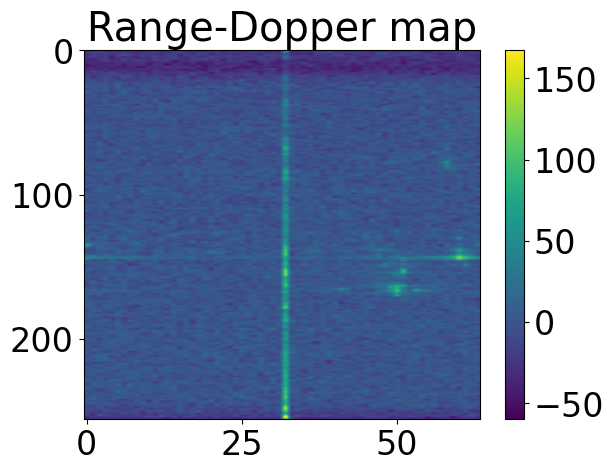

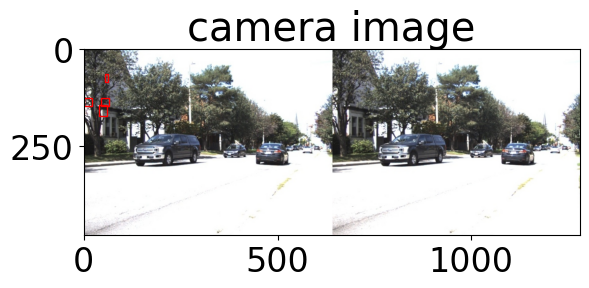

In [119]:
train_dataset = RaddetDataset(data_dir='/home/hawk/Desktop/data/Raddet', split='train')
test_dataset = RaddetDataset(data_dir='/home/hawk/Desktop/data/Raddet', split='test')
RADDet_train_dataset = train_dataset
# Check dataset sizes
print(f'Training dataset size: {len(train_dataset)}')
print(f'Testing dataset size: {len(test_dataset)}')

sample = train_dataset[1]

# Print the sample details including shapes
print(f'Sample spectrum shape: {sample["spectrum"].shape}')
print(f'Sample image filename: {sample["image_filename"]}')
print(f'Number of objects: {len(sample["objects"])}')
for obj in sample["objects"]:
    print(f'Object bbox: {obj["bbox"]}, label: {obj["label"]}, area: {obj["area"]}')


def visualize_sample(sample):
    # Visualize the radar spectrum
    spectrum = sample['spectrum'].numpy()
    plt.imshow(spectrum, aspect='auto')
    plt.title('Range-Dopper map')
    plt.colorbar()
    plt.show()
    
    # Visualize the image with bounding boxes
    image_filename = sample['image_filename']
    image = plt.imread(image_filename)
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    for obj in sample['objects']:
        ymin, xmin, ymax, xmax = obj['bbox']
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        #plt.text(xmin, ymin, f'Label: {obj["label"]}', color='red', fontsize=12)
        
    plt.title('camera image')
    plt.show()

visualize_sample(sample)

#### Erics preprocessing

In [105]:
## steps for generating derivative dataset, with respec tto size for each class.
## 1: find mean and standard deviation for a set of instances for a given class.
## set width of data to mean + stdev
## 

## loop through all original images, get the azimuth center coordinate
## based on azimuth center coordinate and width, check if left and right side of width goes past 0 on the left or past 255 on the right.
## if width extends past 0 on the left, extract 0 to right side of width, then pad 0s to left up to width

## if width extends past 255 to the right, extract left side to 255, and pad 0s up to (width - 255)

## determine three section ranges, if total width % 3 == 0, 3 equal bins, if width % 3 == 1, ex 3, 4, 3, if width % 3 == 2, ex 4, 3, 4.
## set pixel ranges for each of the 3 sections, and take abs(), sum, then log.  Once all data samples have been written, need to compute the mean and st dev across all samples and dimensions.  Rewrite the .npy files with normalized values.
    
label_files = glob.glob("/media/eric/Drive2/RADDet_DATASET/train/gt/*/*.pickle")
RAD_files = glob.glob("/media/eric/Drive2/RADDet_DATASET/train/RAD/*/*.npy")
az_width_mean = 51
range_width_mean = 74 
dopp_width_mean = 51
## The values above were determined by calculating the mean and st dev for each class and using such values for the largest class.  These three number represent mean + st dev for each class.

def slice_rad_file(rad_file, az_left, az_right, range_top, range_bottom, dopp_left, dopp_right):
    ## This function takes a npy file path of the original RADDETR dataset npy tensor along with the 3D extraction boundaries from the original npy tensor.  It returns the final carved npy tensor of the shape (64, 256, 3) which contains signal power for exactly one instance per new npy tensor.
    start_RAD = time.time()
    RAD = np.load(rad_file)
    RAD = np.transpose(RAD, (1, 0, 2)) ## convert from RAD to ARD tensors
    if az_left < 0:
        az_left_boundary = 0
        az_pad_left = -az_left 
    else:
        az_left_boundary = az_left
        az_pad_left = 0
    if az_right > 255:
        az_right_boundary = 255
        az_pad_right = az_right - 255
    else:
        az_right_boundary = az_right
        az_pad_right = 0

    if dopp_left < 0:
        dopp_left_boundary = 0
        dopp_pad_left = 0 ## orig: -dopp_left
    else:
        dopp_left_boundary = dopp_left
        dopp_pad_left = dopp_left ## orig zero
    if dopp_right > 63:
        dopp_right_boundary = 64
        dopp_pad_right = 0  # orig: dopp_right - 63
    else:
        dopp_right_boundary = dopp_right
        dopp_pad_right = 64 - dopp_right    # orig: 0
    
    if range_top < 0:
        range_top_boundary = 0
        range_pad_top = 0 #orig: -range_top 
    else:
        range_top_boundary = range_top
        range_pad_top = range_top # orig: 0
    if range_bottom > 255:
        range_bottom_boundary = 256
        range_pad_bottom = 0  # orig: range_bottom - 255
    else:
        range_bottom_boundary = range_bottom
        range_pad_bottom = 256 - range_bottom # orig: 0

    RD_unpadded = RAD[az_left_boundary:az_right_boundary,range_top_boundary:range_bottom_boundary,dopp_left_boundary:dopp_right_boundary]
    RD_padded = np.pad(RD_unpadded, ((az_pad_left, az_pad_right), (range_pad_top,range_pad_bottom), (dopp_pad_left, dopp_pad_right)))
    if az_width_mean % 3 == 0:
        left_1, right_1 = 0, int(az_width_mean/3)
        left_2, right_2 = int(az_width_mean/3), int(2*az_width_mean/3)
        left_3, right_3 = int(2*az_width_mean/3), az_width_mean
    elif az_width_mean % 3 == 2:
        left_1, right_1 = 0, int(az_width_mean/3) + 1
        left_2, right_2 = int(az_width_mean/3) + 1, int(2*az_width_mean/3) 
        left_3, right_3 = int(2*az_width_mean/3), az_width_mean
    else:
        left_1, right_1 = 0, int(az_width_mean/3) 
        left_2, right_2 = int(az_width_mean/3), int(2*az_width_mean/3) + 1
        left_3, right_3 = int(2*az_width_mean/3) + 1, az_width_mean

    ## absolute value and square
    RD = np.abs(RD_padded)
    RD = pow(RD, 2)
    
    ## separate the three sections
    RD_1 = RD[left_1:right_1,:,:]
    RD_2 = RD[left_2:right_2,:,:]
    RD_3 = RD[left_3:right_3,:,:]
    
    ## sum each section to a single channel
    RD_1 = np.sum(RD_1, axis=0)
    RD_2 = np.sum(RD_2, axis=0)
    RD_3 = np.sum(RD_3, axis=0)

    ## log
    RD_1 = np.log10(RD_1 + 1)
    RD_2 = np.log10(RD_2 + 1)
    RD_3 = np.log10(RD_3 + 1)

    ## stack the three channels to a 3 channel tensor
    RD_3_channel = np.stack([RD_1, RD_2, RD_3], axis=0) 
    
    ## return the new RAD file
    return np.transpose(RD_3_channel, (2, 1, 0))


def get_label_data(label):
    ## This function takes a single label file (pickle file) path from the original RADDET dataset, loops through the object instances, and returns a list for each on the return line: obj_list is the list of class names, az_center_list is the list of all azimuth centers, and so forth.
    start_get_label = time.time()
    obj_list = []
    az_center_list, range_center_list, dopp_center_list = [], [], []
    az_width_list, range_width_list, dopp_width_list = [], [], []
    data = pickle.load(open(label, 'rb'))
    for obj_num, obj in enumerate(data['classes']):
        obj_list.append(obj)
        az_center_list.append(data['boxes'][obj_num][1])
        az_width_list.append(data['boxes'][obj_num][3])
        range_center_list.append(data['boxes'][obj_num][0])
        range_width_list.append(data['boxes'][obj_num][3])
        dopp_center_list.append(data['boxes'][obj_num][2])
        dopp_width_list.append(data['boxes'][obj_num][5])
    return obj_list, az_center_list, az_width_list, range_center_list, range_width_list, dopp_center_list, dopp_width_list


dest_image_dir = "/media/eric/Drive2/RADAR_DERIVATIVE_CROPPED/train/images/"
dest_labels_dir = "/media/eric/Drive2/RADAR_DERIVATIVE_CROPPED/train/labels/"
## Make sure to change these to your local directories

class_labels = {"person":0, "bicycle":1, "car":2, "motorcycle":3, "bus":4, "truck":5}
global_class_count = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
az_running_width = {"car":[],"motorcycle":[],"bicycle":[],"person":[],"truck":[],"bus":[]}
range_running_width = {"car":[],"motorcycle":[],"bicycle":[],"person":[],"truck":[],"bus":[]}
dopp_running_width = {"car":[],"motorcycle":[],"bicycle":[],"person":[],"truck":[],"bus":[]}
az_avg_width = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
range_avg_width = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
dopp_avg_width = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
az_sd_width = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
range_sd_width = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
dopp_sd_width = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
new_sample_count = 0
for label_file in tqdm(sorted(label_files)):
    part, label_base = label_file.split('/')[-2:]
    image_name = "/media/eric/Drive2/RADDet_DATASET/train/RAD/" + part + "/" + label_base.split('.')[0] + ".npy"
    class_count = {"car":0,"motorcycle":0,"bicycle":0,"person":0,"truck":0,"bus":0}
    obj_list, az_cent, az_width, range_cent, range_width, dopp_cent, dopp_width = get_label_data(label_file)
    for i, obj in enumerate(obj_list):
        class_count[obj] += 1
        global_class_count[obj] += 1
        #az_running_width[obj].append(az_width[i]) ## these lines only needed for computing mean and stdev for all channels.
        #range_running_width[obj].append(range_width[i])
        #dopp_running_width[obj].append(dopp_width[i])
    
        if (az_cent[i] + az_width_mean/2) % 1 == 0:
            az_left = int(az_cent[i] - az_width_mean/2)
            az_right = int(az_cent[i] + az_width_mean/2)
        else:
            az_left = int(az_cent[i] +.5 - az_width_mean/2)
            az_right = int(az_cent[i] + .5 + az_width_mean/2)

        if (range_cent[i] + range_width_mean/2) % 1 == 0:
            range_top = int(range_cent[i] - range_width_mean/2)
            range_bottom = int(range_cent[i] + range_width_mean/2)
        else:
            range_top = int(range_cent[i] +.5 - range_width_mean/2)
            range_bottom = int(range_cent[i] + .5 + range_width_mean/2)
        
        if (dopp_cent[i] + dopp_width_mean/2) % 1 == 0:
            dopp_left = int(dopp_cent[i] - dopp_width_mean/2)
            dopp_right = int(dopp_cent[i] + dopp_width_mean/2)
        else:
            dopp_left = int(dopp_cent[i] +.5 - dopp_width_mean/2)
            dopp_right = int(dopp_cent[i] + .5 + dopp_width_mean/2)

        RAD_3_ch = slice_rad_file(image_name,int(az_left), int(az_right), int(range_top), int(range_bottom), int(dopp_left), int(dopp_right))
        new_RAD_file_name = label_base.split(".")[0] + "_" + obj + "_" + str(class_count[obj]) + ".npy"
        total_new_file_name = os.path.join(dest_image_dir, new_RAD_file_name)
        
        new_label_name = label_base.split(".")[0] + "_" + obj + "_" + str(class_count[obj]) + ".txt"
        total_new_label_file_name = os.path.join(dest_labels_dir, new_label_name)
        label_line = " ".join([str(class_labels[obj]),str(int(dopp_cent[i])), str(int(range_cent[i])), str(int(dopp_width[i])), str(int(range_width[i]))])
        new_sample_count += 1
        if new_sample_count % 100 == 0: print(f"Sample Count: {new_sample_count}")
        with open(total_new_label_file_name, 'w') as f:
            f.write(label_line)
        
        with open(total_new_file_name, 'wb') as f:
            np.save(f, RAD_3_ch)        
        
        ## visualize 1 sample at a time: RD map and stereo image
        #visualize(image_name, total_new_file_name)


## The code block below is only used to comptue the radar transform means and standard deviations for each channel.  (The torch transforms when training and inferencing).
'''
for obj in az_avg_width:
    az_avg_width[obj] = np.mean(az_running_width[obj])
    az_sd_width[obj] = np.std(az_running_width[obj])
    range_avg_width[obj] = np.mean(range_running_width[obj])
    range_sd_width[obj] = np.std(range_running_width[obj])
    dopp_avg_width[obj] = np.mean(dopp_running_width[obj])
    dopp_sd_width[obj] = np.std(dopp_running_width[obj])
    print(f"{obj}, AZ avg: {az_avg_width[obj]}, AZ SD: {az_sd_width[obj]}, RANGE avg: {range_avg_width[obj]}, RANGE sd width: {range_sd_width[obj]}, Dopp avg width: {dopp_avg_width[obj]}, Dopp sd width: {dopp_sd_width[obj]}")
'''


0it [00:00, ?it/s]


'\nfor obj in az_avg_width:\n    az_avg_width[obj] = np.mean(az_running_width[obj])\n    az_sd_width[obj] = np.std(az_running_width[obj])\n    range_avg_width[obj] = np.mean(range_running_width[obj])\n    range_sd_width[obj] = np.std(range_running_width[obj])\n    dopp_avg_width[obj] = np.mean(dopp_running_width[obj])\n    dopp_sd_width[obj] = np.std(dopp_running_width[obj])\n    print(f"{obj}, AZ avg: {az_avg_width[obj]}, AZ SD: {az_sd_width[obj]}, RANGE avg: {range_avg_width[obj]}, RANGE sd width: {range_sd_width[obj]}, Dopp avg width: {dopp_avg_width[obj]}, Dopp sd width: {dopp_sd_width[obj]}")\n'

## Carrada Dataset

### Processed Carrada

#### Define paths

In [106]:
seq_name = '2020-02-28-13-09-58'
instances = ['001114', '001115']
frame_name = '000117'
carrada = '/home/hawk/Desktop/data/carrada/Carrada'
seq_path = os.path.join(carrada, seq_name)
rd_path = os.path.join(seq_path, 'range_doppler_numpy', frame_name + '.npy')
ra_path = os.path.join(seq_path, 'range_angle_numpy', frame_name + '.npy')
img_path = os.path.join(seq_path, 'camera_images', frame_name + '.jpg')
annotations_path = os.path.join(carrada, 'annotations_frame_oriented.json')

In [107]:
print(seq_path)
print(rd_path)
print(ra_path)
print(img_path)
print(annotations_path)

/home/hawk/Desktop/data/carrada/Carrada/2020-02-28-13-09-58
/home/hawk/Desktop/data/carrada/Carrada/2020-02-28-13-09-58/range_doppler_numpy/000117.npy
/home/hawk/Desktop/data/carrada/Carrada/2020-02-28-13-09-58/range_angle_numpy/000117.npy
/home/hawk/Desktop/data/carrada/Carrada/2020-02-28-13-09-58/camera_images/000117.jpg
/home/hawk/Desktop/data/carrada/Carrada/annotations_frame_oriented.json


#### load ra and rd maps

In [108]:
with open(annotations_path, 'r') as fp:
    annotations = json.load(fp)
annotations = annotations[seq_name][frame_name]  # Keep annotations of interest
# Range-angle and range-Doppler matrices
'''
# the RA and RD matrices can be computed directly from the RAD tensor
rad_matrix = np.load(rad_path)
data_transformer = DataTransformer(rad_matrix)
ra_matrix = data_transformer.to_ra()
rd_matrix = data_transformer.to_rd()
'''
ra_matrix = np.load(ra_path)
rd_matrix = np.load(rd_path)

In [109]:
annotations

{'001114': {'range_doppler': {'sparse': [[167, 15],
    [167, 15],
    [168, 11],
    [169, 13],
    [168, 13],
    [168, 15],
    [168, 15],
    [168, 17],
    [168, 18],
    [169, 18],
    [170, 15],
    [170, 15],
    [170, 17],
    [170, 18],
    [171, 15],
    [171, 15],
    [171, 17],
    [171, 18]],
   'box': [[167, 11], [171, 18]],
   'dense': [[165, 13],
    [165, 14],
    [165, 15],
    [165, 16],
    [165, 17],
    [166, 9],
    [166, 10],
    [166, 11],
    [166, 12],
    [166, 13],
    [166, 14],
    [166, 15],
    [166, 16],
    [166, 17],
    [166, 18],
    [166, 19],
    [166, 20],
    [167, 9],
    [167, 10],
    [167, 11],
    [167, 12],
    [167, 13],
    [167, 14],
    [167, 15],
    [167, 16],
    [167, 17],
    [167, 18],
    [167, 19],
    [167, 20],
    [168, 9],
    [168, 10],
    [168, 11],
    [168, 12],
    [168, 13],
    [168, 14],
    [168, 15],
    [168, 16],
    [168, 17],
    [168, 18],
    [168, 19],
    [168, 20],
    [169, 9],
    [169, 10],
    [169

#### display an example image

Camera image of the scene 2020-02-28-13-09-58, frame 000117


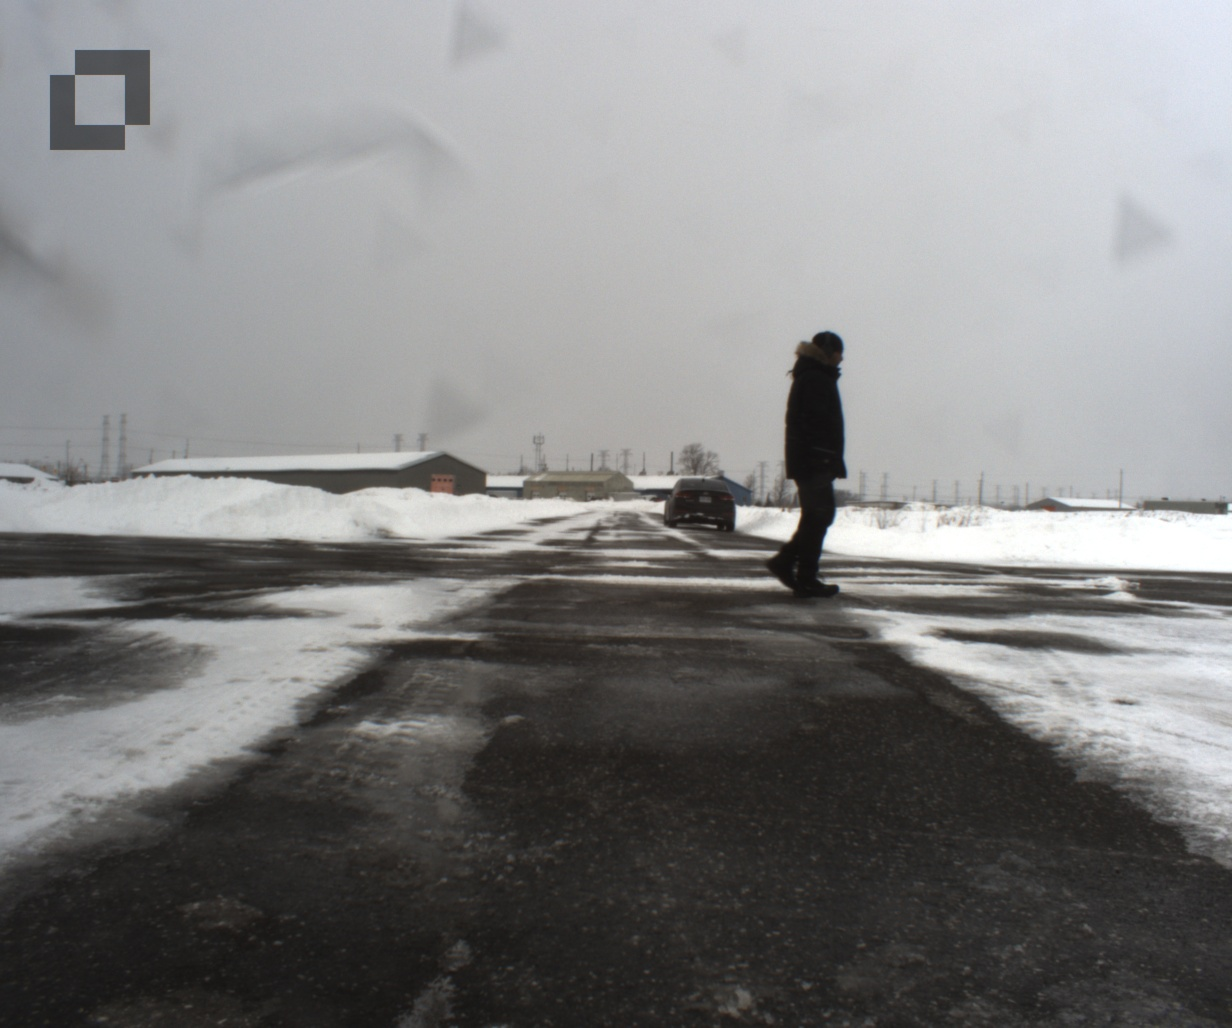

In [110]:
# Camera image of the scene
print('Camera image of the scene {}, frame {}'.format(seq_name, frame_name))
img = Image(img_path)
display(img)

#### display the rd map with the annotations

Raw Range-Doppler representation:


<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?


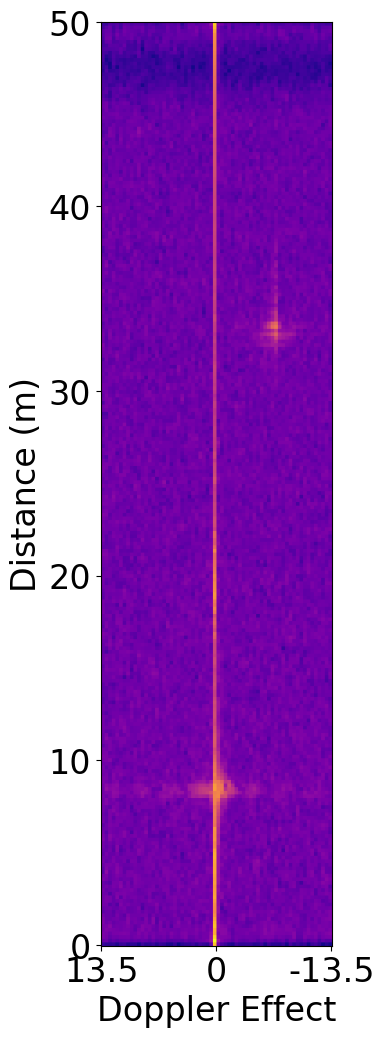

Range-Doppler with sparse annotations:


/tmp/ipykernel_240874/1529025922.py:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if annotation_type is 'sparse':
/tmp/ipykernel_240874/1529025922.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif annotation_type is 'dense':


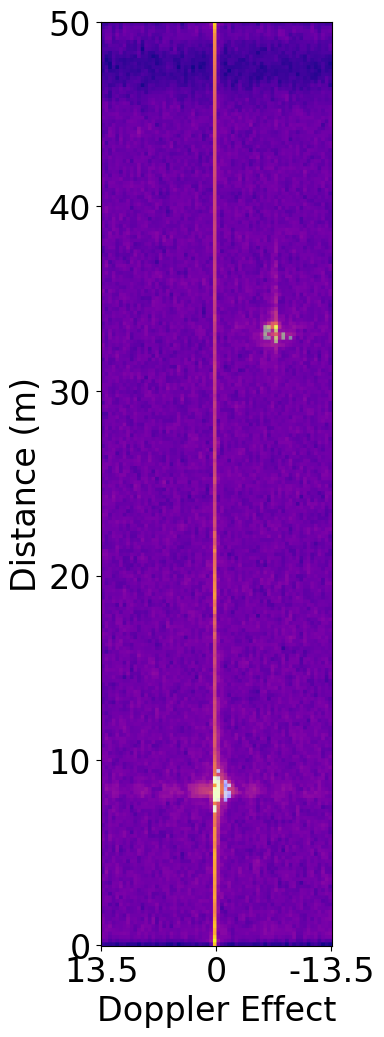

Range-Doppler with dense annotations:


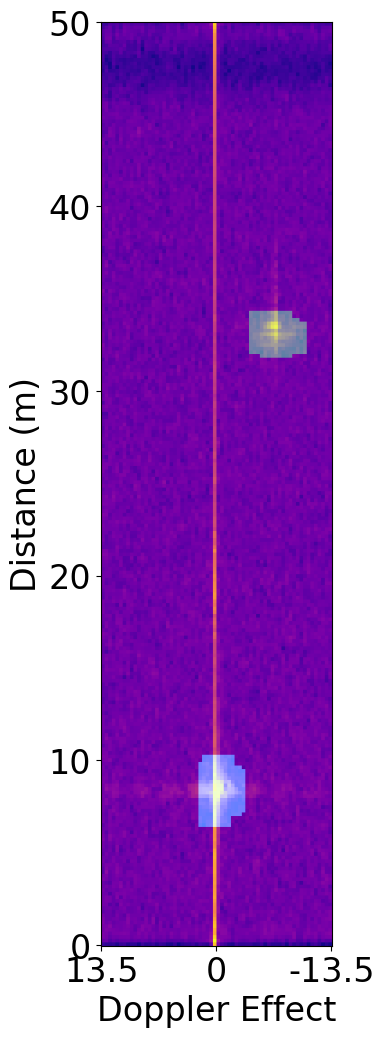

Range-Doppler with box annotations:


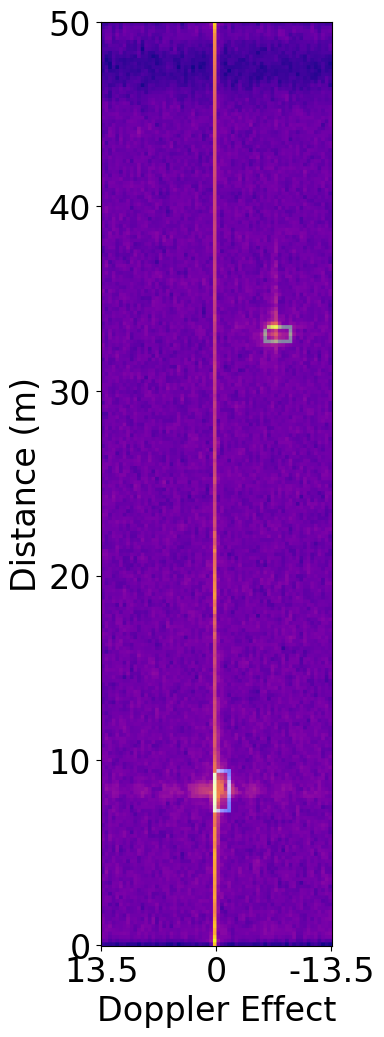

In [111]:
# Range-Doppler visualization
signal_visualizer = SignalVisualizer(rd_matrix)
print('Raw Range-Doppler representation:')
signal_visualizer.save_scale(path='.', signal_type='range_doppler', color_scale=False,
                             rotation=True, save_img=False, plot_img=True)
for annotation_type in ['sparse', 'dense', 'box']:
    for i, instance in enumerate(instances):
        points = annotations[instance]['range_doppler'][annotation_type]
        annot_generator = AnnotationGenerator(rd_matrix.shape, points)
        if annotation_type is 'sparse':
            annots = annot_generator.get_points()
        elif annotation_type is 'dense':
            annots = annot_generator.get_mask()
        else:
            annots = annot_generator.get_box()
        signal_visualizer.add_annotation(i, annots, annotation_type)
    print('Range-Doppler with {} annotations:'.format(annotation_type))
    signal_visualizer.save_multiple_annotations(path='/root/workspace/temp/rd_{}.png'.format(annotation_type),
                                                signal_type='range_doppler', color_scale=False,
                                                rotation=True, save_img=False, plot_img=True)
    signal_visualizer.reset_annotation()

#### display the ra map with the annotations

<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:12: SyntaxWarning: "is" with a literal. Did you mean "=="?


Raw Range-Angle representation:


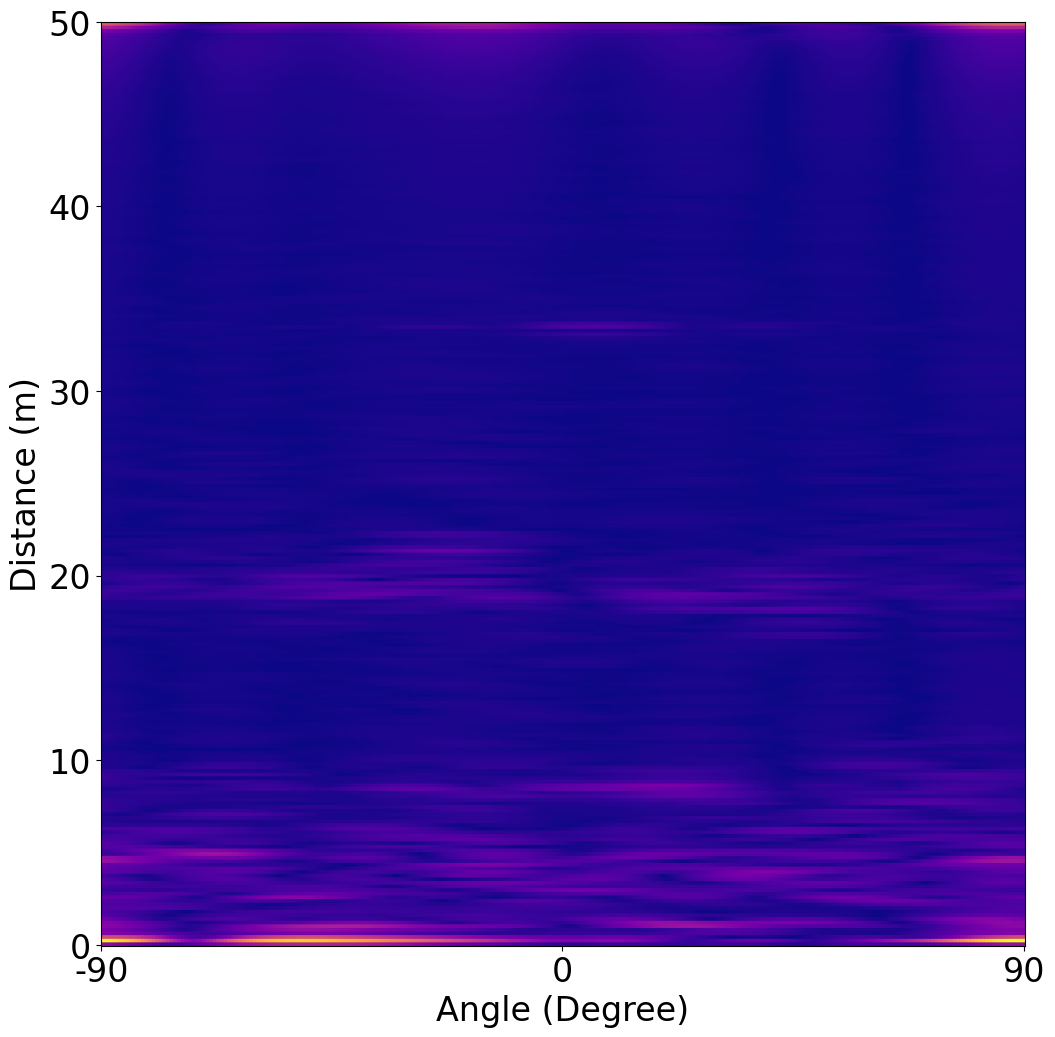

/tmp/ipykernel_240874/3271338884.py:10: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if annotation_type is 'sparse':
/tmp/ipykernel_240874/3271338884.py:12: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif annotation_type is 'dense':


Range-Angle with sparse annotations:


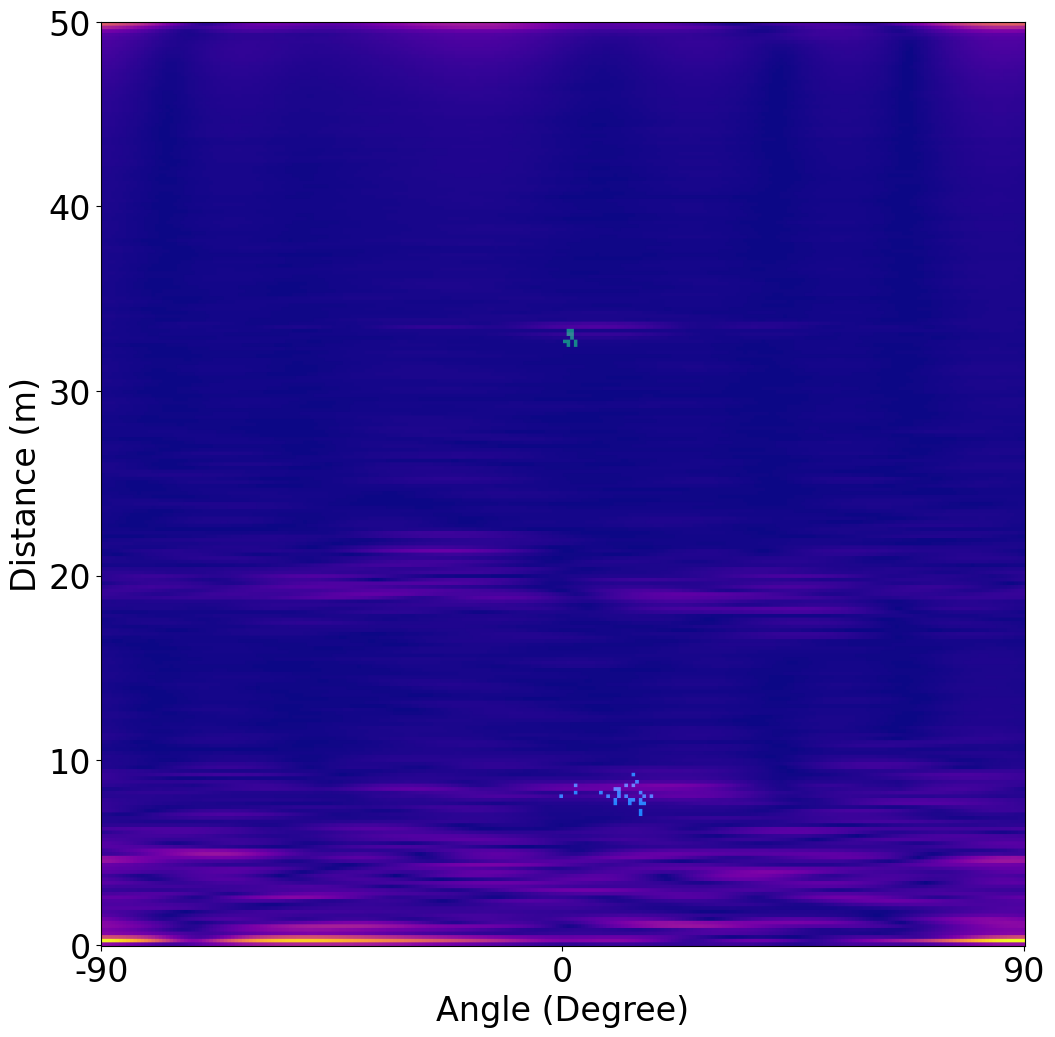

Range-Angle with dense annotations:


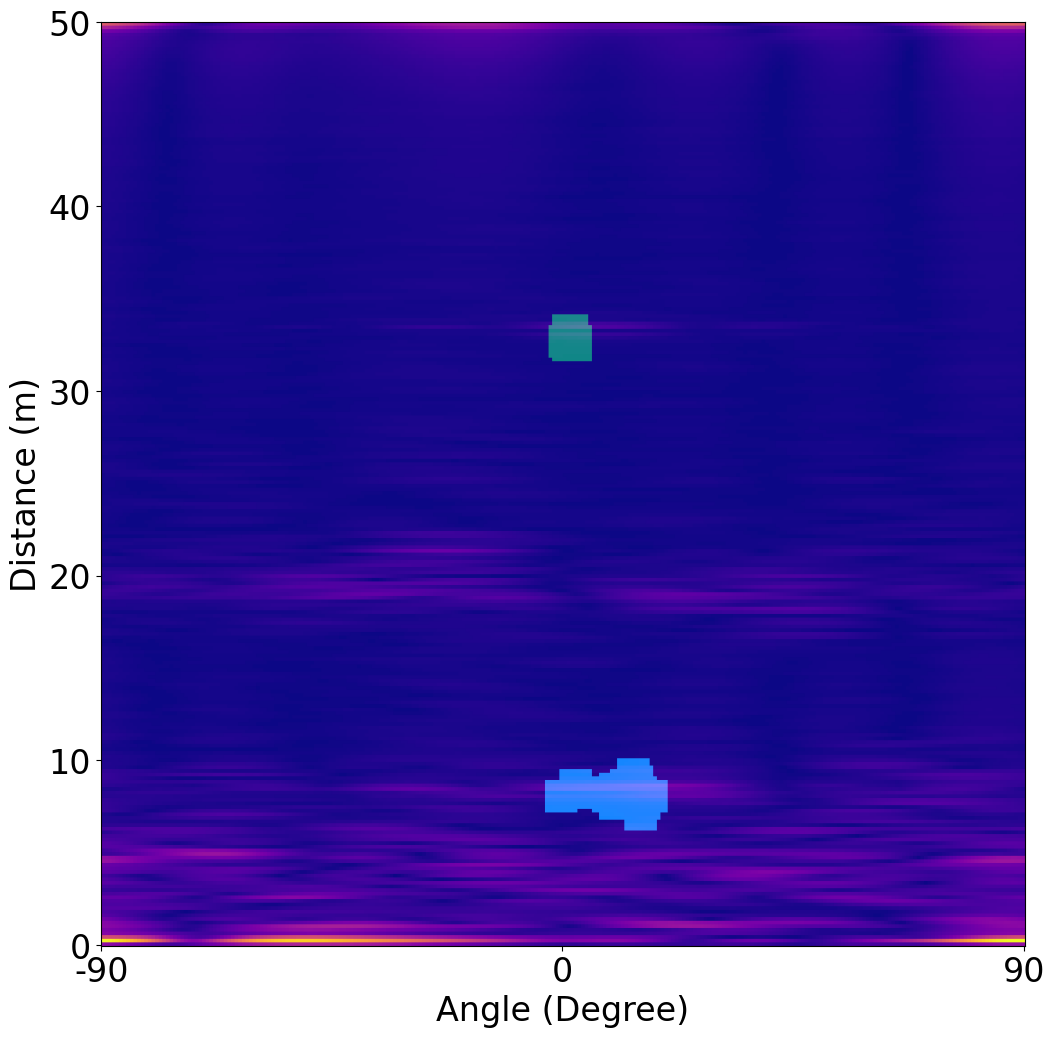

Range-Angle with box annotations:


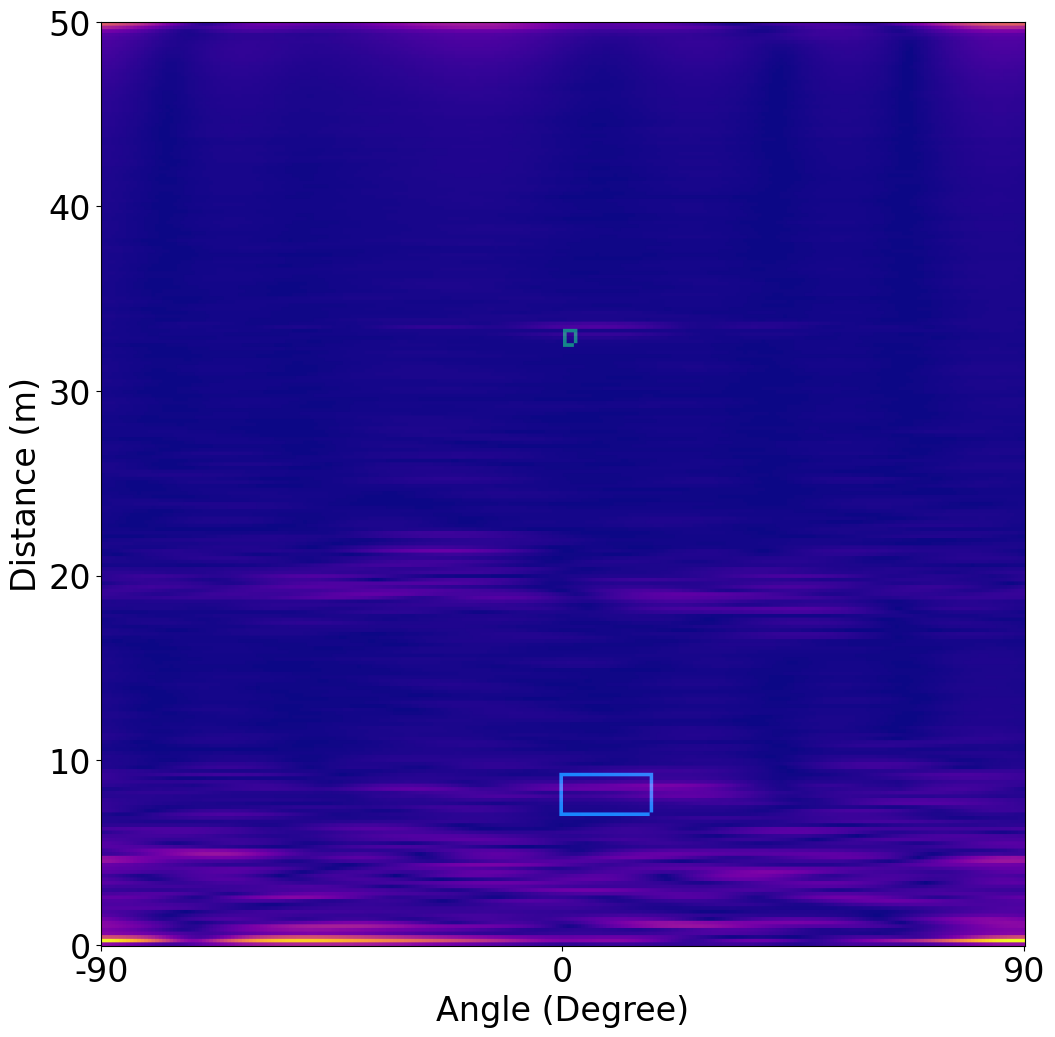

In [112]:
# Range-Angle visualization
signal_visualizer = SignalVisualizer(ra_matrix)
print('Raw Range-Angle representation:')
signal_visualizer.save_scale(path='.', signal_type='range_angle', color_scale=False,
                             rotation=False, save_img=False, plot_img=True)
for annotation_type in ['sparse', 'dense', 'box']:
    for i, instance in enumerate(instances):
        points = annotations[instance]['range_angle'][annotation_type]
        annot_generator = AnnotationGenerator(ra_matrix.shape, points)
        if annotation_type is 'sparse':
            annots = annot_generator.get_points()
        elif annotation_type is 'dense':
            annots = annot_generator.get_mask()
        else:
            annots = annot_generator.get_box()
        signal_visualizer.add_annotation(i, annots, annotation_type)
    print('Range-Angle with {} annotations:'.format(annotation_type))
    signal_visualizer.save_multiple_annotations(path='/root/workspace/temp/ra_{}.png'.format(annotation_type),
                                                signal_type='range_angle', color_scale=False,
                                                rotation=False, save_img=False, plot_img=True)
    signal_visualizer.reset_annotation()

### New CARRADA class

In [131]:

class CarradaDataset(Dataset):
    def __init__(self, root_dir, split, input_type="RD"):
        self.root_dir = root_dir
        self.split = split
        self.input_type = input_type

        self.annotations_path = os.path.join(root_dir, 'annotations_frame_oriented.json')
        self.annotations, self.seq_ref = self._load_annotation(self.annotations_path)

        self.spectrum_type = 'range_doppler' if input_type == "RD" else 'range_angle'
        self.height, self.width = (256, 64) if input_type == "RD" else (256, 256)
        
        self.exceptions = [
            '2019-09-16-12-52-12/camera_images/001015.jpg', '2019-09-16-12-52-12/camera_images/001016.jpg',
            '2019-09-16-13-14-29/camera_images/000456.jpg', '2020-02-28-12-12-16/camera_images/000489.jpg',
            '2020-02-28-12-12-16/camera_images/000490.jpg', '2020-02-28-12-12-16/camera_images/000491.jpg',
            '2020-02-28-13-06-53/camera_images/000225.jpg', '2020-02-28-13-06-53/camera_images/000226.jpg',
            '2020-02-28-13-10-51/camera_images/000247.jpg', '2020-02-28-13-10-51/camera_images/000248.jpg',
            '2020-02-28-13-10-51/camera_images/000249.jpg', '2020-02-28-13-13-43/camera_images/000216.jpg',
            '2020-02-28-13-13-43/camera_images/000217.jpg', '2020-02-28-13-15-36/camera_images/000169.jpg',
            '2020-02-28-12-13-54/camera_images/000659.jpg', '2020-02-28-12-13-54/camera_images/000660.jpg',
            '2020-02-28-13-07-38/camera_images/000279.jpg', '2020-02-28-13-07-38/camera_images/000280.jpg'
        ]

        self.sequences = [seq for seq in self.seq_ref if self.seq_ref[seq]['split'] == self._get_split_name()]
        self.dataset = self._create_dataset()

    def _get_split_name(self):
        if self.split == 'train':
            return "Train"
        elif self.split == 'val':
            return "Validation"
        elif self.split == 'test':
            return "Test"
        else:
            raise ValueError("Invalid split name")

    def _create_dataset(self):
        dataset = []
        sequence_id = 0
        for sequence in self.sequences:
            sequence_id += 1
            current_annotations = self.annotations[sequence]
            for frame in current_annotations:
                objects = []
                spectrum_fn = os.path.join(sequence, self.spectrum_type + '_processed', frame.zfill(6) + '.npy')
                image_fn = os.path.join(sequence, 'camera_images', frame.zfill(6) + '.jpg')

                if image_fn not in self.exceptions:
                    instances_annot = current_annotations[frame]
                    for instance in instances_annot:
                        in_polygon = instances_annot[instance][self.spectrum_type]['dense']
                        bbox, area = self._build_bbox(in_polygon)
                        label = instances_annot[instance][self.spectrum_type]['label']
                        objects.append({
                            'bbox': bbox,
                            'label': label - 1,
                            'area': area,
                            'id': instance
                        })

                    dataset.append({
                        'spectrum': os.path.join(self.root_dir, spectrum_fn),
                        'spectrum/filename': spectrum_fn,
                        'sequence/id': sequence_id,
                        'image': os.path.join(self.root_dir, image_fn),
                        'image/filename': image_fn,
                        'objects': objects
                    })

        return dataset

    def _build_bbox(self, polygon):
        x, y = zip(*polygon)
        y1, x1, y2, x2 = min(y), min(x), max(y), max(x)
        bbox = [y1, x1, y2, x2]
        area = self._compute_area(bbox)
        #return [y1 / self.height, x1 / self.width, y2 / self.height, x2 / self.width], area
        return [y1 / self.height, x1 / self.width, y2 / self.height, x2 / self.width], area

    def _compute_area(self, box):
        y1, x1, y2, x2 = box
        return (x2 - x1) * (y2 - y1)

    def _load_annotation(self, annotation_path):
        with open(annotation_path) as annotations:
            annotations = json.load(annotations)
        with open(os.path.join(self.root_dir, "data_seq_ref.json")) as seq_ref:
            seq_ref = json.load(seq_ref)
        return annotations, seq_ref

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        spectrum = np.load(item['spectrum']).astype(np.float32)
        image = read_image(item['image']).float() / 255.0

        return {
            'spectrum': torch.tensor(spectrum),
            'spectrum_filename': item['spectrum/filename'],
            'sequence_id': item['sequence/id'],
            'image': image,
            'image_filename': item['image'],
            'objects': item['objects']
        }
    

root_dir = "/home/hawk/Desktop/data/carrada/Carrada"
train_dataset = CarradaDataset(root_dir=root_dir, split='train')
val_dataset = CarradaDataset(root_dir=root_dir, split='val')
test_dataset = CarradaDataset(root_dir=root_dir, split='test')

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

CARRADA_train_dataset = train_dataset

#### Visualize

Total number of samples in the dataset: 8074
Sample spectrum shape: torch.Size([256, 64])
Sample image shape: torch.Size([3, 1028, 1232])
Image filename: /home/hawk/Desktop/data/carrada/Carrada/2020-02-28-12-12-16/camera_images/000153.jpg
Number of objects: 2
Object bbox: [0.12109375, 2.0625, 0.14453125, 2.15625], label: 0, area: 36
Object bbox: [0.08984375, 1.625, 0.1328125, 1.75], label: 0, area: 88


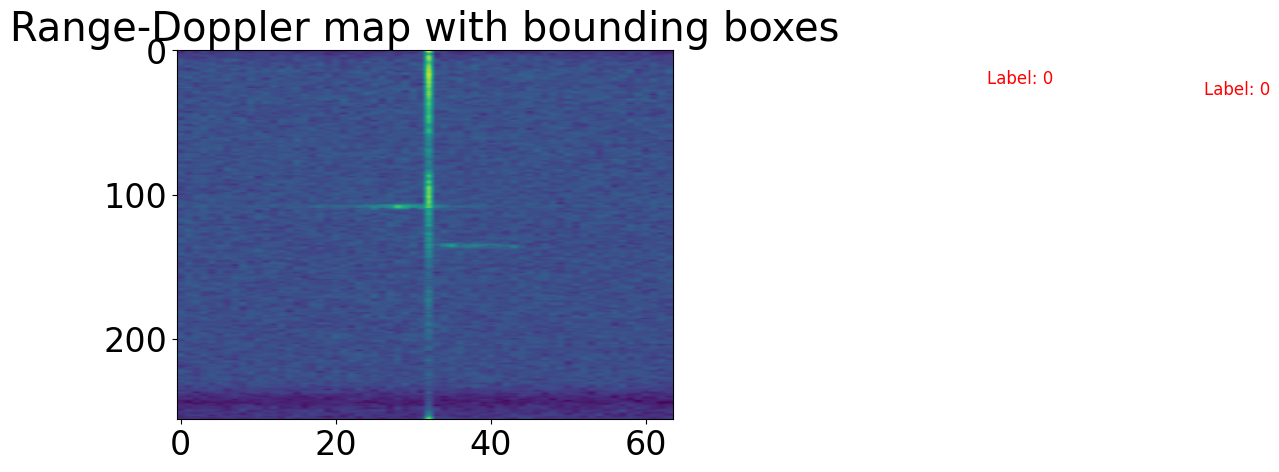

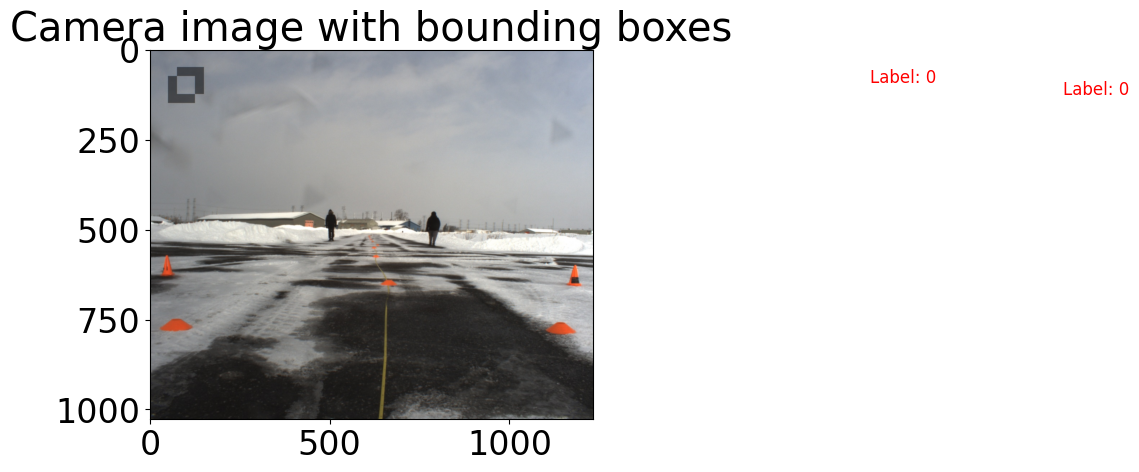

In [132]:
def visualize_sample(dataset, sample_index=0):
    # Print the number of samples in the dataset
    print(f'Total number of samples in the dataset: {len(dataset)}')
    
    # Retrieve the sample
    sample = dataset[sample_index]
    
    # Print the sample details including shapes
    print(f'Sample spectrum shape: {sample["spectrum"].shape}')
    print(f'Sample image shape: {sample["image"].shape}')
    print(f'Image filename: {sample["image_filename"]}')
    print(f'Number of objects: {len(sample["objects"])}')
    for obj in sample["objects"]:
        print(f'Object bbox: {obj["bbox"]}, label: {obj["label"]}, area: {obj["area"]}')

    # Visualize the radar spectrum with bounding boxes
    spectrum = sample['spectrum'].numpy()
    fig, ax = plt.subplots(1)
    ax.imshow(spectrum, aspect='auto')
    
    for obj in sample['objects']:
        ymin, xmin, ymax, xmax = obj['bbox']
        ymin, xmin, ymax, xmax = ymin * spectrum.shape[0], xmin * spectrum.shape[1], ymax * spectrum.shape[0], xmax * spectrum.shape[1]
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, f'Label: {obj["label"]}', color='red', fontsize=12)
    
    plt.title('Range-Doppler map with bounding boxes')
    plt.show()

    # Visualize the image with bounding boxes
    image_tensor = sample['image']
    image = to_pil_image(image_tensor)
    fig, ax = plt.subplots(1)
    ax.imshow(image)
    
    for obj in sample['objects']:
        ymin, xmin, ymax, xmax = obj['bbox']
        ymin, xmin, ymax, xmax = ymin * image.height, xmin * image.width, ymax * image.height, xmax * image.width
        width, height = xmax - xmin, ymax - ymin
        rect = patches.Rectangle((xmin, ymin), width, height, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        plt.text(xmin, ymin, f'Label: {obj["label"]}', color='red', fontsize=12)
        
    plt.title('Camera image with bounding boxes')
    plt.show()

# Example usage
train_dataset = CarradaDataset(root_dir='/home/hawk/Desktop/data/carrada/Carrada', split='train')
visualize_sample(train_dataset, sample_index=5000)


## Summary for RADDet and CARRADA

In [149]:

sample = RADDet_train_dataset[34]

print("RADDet Dataset Sample Details:")
print("\n")
print(f'Sample spectrum shape: {sample["spectrum"].shape}')
print(f'Image filename: {sample["image_filename"]}')
print(f'Number of objects: {len(sample["objects"])}')
for obj in sample["objects"]:
    print(f'Object bbox: {obj["bbox"]}, label: {obj["label"]}, area: {obj["area"]}')
print("\n")


sample = CARRADA_train_dataset[5000]

print("CARRADA Dataset Sample Details:")
print("\n")
print(f'Sample spectrum shape: {sample["spectrum"].shape}')
print(f'Image filename: {sample["image_filename"]}')
print(f'Number of objects: {len(sample["objects"])}')
for obj in sample["objects"]:
    print(f'Object bbox: {obj["bbox"]}, label: {obj["label"]}, area: {obj["area"]}')
    


RADDet Dataset Sample Details:


Sample spectrum shape: torch.Size([256, 64])
Image filename: /home/hawk/Desktop/data/Raddet/train/stereo_image/part_9/002052.jpg
Number of objects: 2
Object bbox: [156, 0, 179, 63], label: 2, area: 1449
Object bbox: [123, 29, 134, 35], label: 2, area: 66


CARRADA Dataset Sample Details:


Sample spectrum shape: torch.Size([256, 64])
Image filename: /home/hawk/Desktop/data/carrada/Carrada/2020-02-28-12-12-16/camera_images/000153.jpg
Number of objects: 2
Object bbox: [0.12109375, 2.0625, 0.14453125, 2.15625], label: 0, area: 36
Object bbox: [0.08984375, 1.625, 0.1328125, 1.75], label: 0, area: 88
